In [1]:
%config InlineBackend.rc = {'figure.figsize': (10,6)}
%matplotlib inline

## Poisson equation with scikit-fem

This example solves the Poisson problem using [scikit-fem](https://scikit-fem.readthedocs.io/) using data generated by Nanomesh. We solve the Poisson problem $-\Delta u = 1$ with the boundary condition $u=0$.

This an adaptation of [example 1](https://scikit-fem.readthedocs.io/en/latest/listofexamples.html#example-1-poisson-equation-with-unit-load).

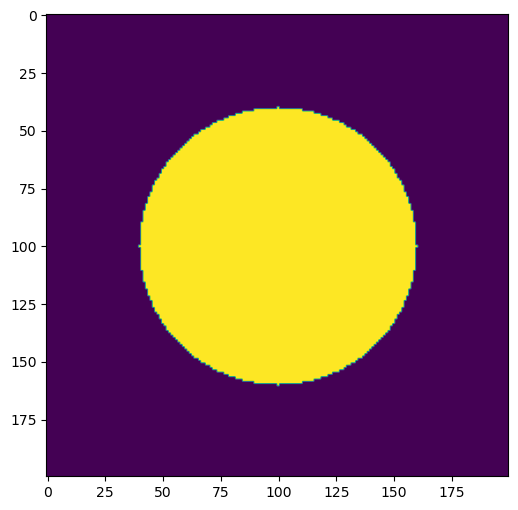

In [2]:
import numpy as np
from skimage.morphology import disk
import matplotlib.pyplot as plt

H, L = 200, 200
Hmid = int(H/2)
Lmid = int(L/2)
r = 60

data = np.zeros((H, L))
data[Hmid-r: Hmid+1+r, Lmid-r:Lmid+1+r] += disk(r)

plt.figure()
plt.imshow(data)

Generate a triangle mesh using `Nanomesh.Mesher`. The triangles that don't belong to the circle are removed.

<AxesSubplot:title={'center':'triangle mesh'}>

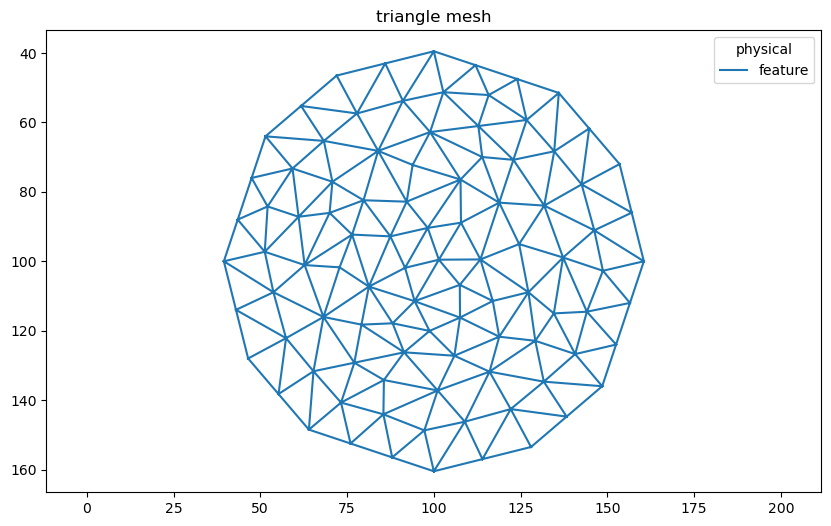

In [3]:
from nanomesh import Mesher

mesher = Mesher(data)
mesher.generate_contour(max_edge_dist=10, precision=5)
mesh = mesher.triangulate(opts='q30a100')
triangles = mesh.get('triangle')
triangles.remove_cells(label=1, key='physical')

triangles.plot()

### Converting to a scikit-fem mesh type

Converting to skfem [data types](https://scikit-fem.readthedocs.io/en/latest/api.html#class-meshtri) is straightforward. Note that the points and cells arrays must be transposed.

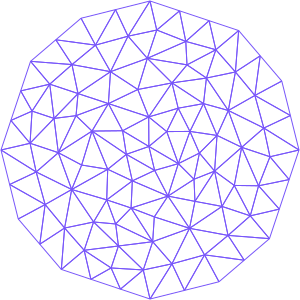

In [4]:
from skfem import MeshTri

p = triangles.points.T
t = triangles.cells.T

m = MeshTri(p, t)
m

### Setting up and solving the PDE

The following code was re-used from [here](https://github.com/kinnala/scikit-fem/blob/master/docs/examples/ex01.py).

In [5]:
from skfem import *
from skfem.helpers import dot, grad

e = ElementTriP1()

basis = Basis(m, e)

# this method could also be imported from skfem.models.laplace
@BilinearForm
def laplace(u, v, _):
    return dot(grad(u), grad(v))


# this method could also be imported from skfem.models.unit_load
@LinearForm
def rhs(v, _):
    return 1.0 * v

A = asm(laplace, basis)
b = asm(rhs, basis)
# or:
# A = laplace.assemble(basis)
# b = rhs.assemble(basis)

# enforce Dirichlet boundary conditions
A, b = enforce(A, b, D=m.boundary_nodes())

# solve -- can be anything that takes a sparse matrix and a right-hand side
x = solve(A, b)

Initializing CellBasis(MeshTri1, ElementTriP1)
Initializing finished.
Assembling 'laplace'.
Assembling finished.
Assembling 'rhs'.
Assembling finished.
Solving linear system, shape=(96, 96).
Solving done.


### Visualize the result

The result can be visualized using matplotlib.

<AxesSubplot:>

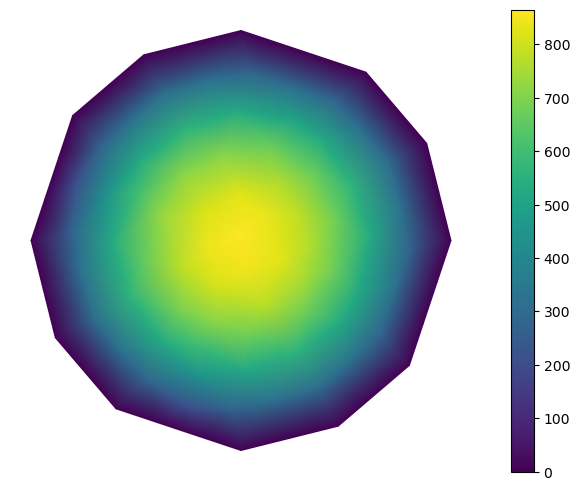

In [6]:
def visualize():
    from skfem.visuals.matplotlib import plot
    return plot(m, x, shading='gouraud', colorbar=True)

visualize()

### Discontinuous Galerkin

The next cells show how the same problem can be approached using the Discontinuous Galerkin method.

This is an adaptation of [example 7](https://scikit-fem.readthedocs.io/en/latest/listofexamples.html#example-7-discontinuous-galerkin-method).

The next cell sets up the data as before, this time using the blobs data set.

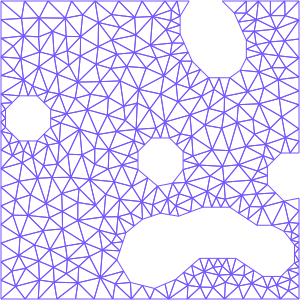

In [7]:
import numpy as np
from skimage.morphology import disk
from nanomesh.data import binary_blobs2d

data = binary_blobs2d(length=100, seed=96)

from nanomesh import Mesher

mesher = Mesher(data)
mesher.generate_contour(max_edge_dist=3, precision=1)
mesh = mesher.triangulate(opts='q30a25')
triangles = mesh.get('triangle')
triangles.remove_cells(label=2, key='physical')

p = triangles.points.T
t = triangles.cells.T

m = MeshTri(p, t)
m

### Setting up and solving the PDE #2

The source-code was re-used from [here](https://github.com/kinnala/scikit-fem/blob/master/docs/examples/ex07.py).

In [8]:
from skfem import *
from skfem.helpers import grad, dot, jump
from skfem.models.poisson import laplace, unit_load

e = ElementTriDG(ElementTriP4())
alpha = 1e-3

ib = Basis(m, e)
bb = FacetBasis(m, e)
fb = [InteriorFacetBasis(m, e, side=i) for i in [0, 1]]

@BilinearForm
def dgform(u, v, p):
    ju, jv = jump(p, u, v)
    h = p.h
    n = p.n
    return ju * jv / (alpha * h) - dot(grad(u), n) * jv - dot(grad(v), n) * ju

@BilinearForm
def nitscheform(u, v, p):
    h = p.h
    n = p.n
    return u * v / (alpha * h) - dot(grad(u), n) * v - dot(grad(v), n) * u

A = asm(laplace, ib)
B = asm(dgform, fb, fb)
C = asm(nitscheform, bb)
b = asm(unit_load, ib)

x = solve(A + B + C, b)

M, X = ib.refinterp(x, 4)

Initializing CellBasis(MeshTri1, ElementDG)
Initializing finished.
Initializing BoundaryFacetBasis(MeshTri1, ElementDG)
Initializing finished.
Initializing InteriorFacetBasis(MeshTri1, ElementDG)
Initializing finished.
Initializing InteriorFacetBasis(MeshTri1, ElementDG)
Initializing finished.
Assembling 'laplace'.
Assembling finished.
Assembling 'dgform'.
Assembling finished.
Assembling 'nitscheform'.
Assembling finished.
Assembling 'unit_load'.
Assembling finished.
Solving linear system, shape=(9225, 9225).
Solving done.


### Visualize the result #2

<AxesSubplot:>

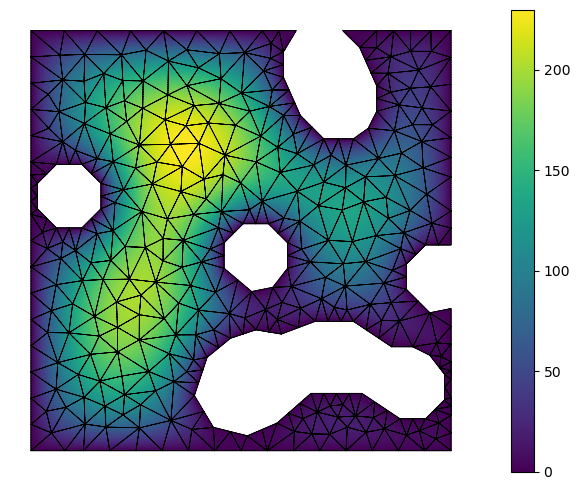

In [9]:
def visualize():
    from skfem.visuals.matplotlib import plot, draw
    ax = draw(M, boundaries_only=True)
    return plot(M, X, shading="gouraud", ax=ax, colorbar=True)

visualize()